# Network Flow Data Cleaning
This notebook cleans network flow data by standardizing direction values and removing duplicates.

## 0. Import Libraries & uploading dataset

In [19]:
import pandas as pd
import os
# Necessario per estrarre la parte numerica dai nomi dei file
import re

#from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [20]:
# Uploading the dataset

# --- 1. Variabili di Input e Generazione Nome Cartella ---
# Devi definire qui i tuoi dataset per generare il nome della cartella.
dataset_filenames = [
    '10-51-rbot-multi.csv',
    '4-45-rbot-single.csv'
]
'''
    '9-50-neris-multi.csv', 
    '10-51-rbot-multi.csv'

    '10-51-rbot-multi.csv',
    '6-47-donbot-single.csv'
'''

path = "../data/CTU-datasets"
fullpath = os.path.join(path, dataset_filenames[0])
fullpath = os.path.join(path, dataset_filenames[1])

data1 = pd.read_csv(fullpath, sep=",")
data1['sTos'] = data1['sTos'].astype('Int64')
data1['dTos'] = data1['dTos'].astype('Int64')

print("Shape", data1.shape)
#print(data1.info())

data2 = pd.read_csv(fullpath, sep=",")
data2['sTos'] = data2['sTos'].astype('Int64')
data2['dTos'] = data2['dTos'].astype('Int64')

print("Shape", data2.shape)

#data = pd.concat([data, data2], ignore_index=True)
#print("Shape", data.shape)

Shape (1121076, 15)
Shape (1121076, 15)


## 1. Checking and fixing bad labels

In [21]:
# Check unique values in the Dir column
for data in [data1, data2]:
    print("Unique direction values:")
    print(data['Dir'].value_counts())

    # Remove any whitespace
    data['Dir'] = data['Dir'].str.strip()

    # Drop row with invalid 'Dir' value: 'who'
    data = data[data['Dir'] != 'who']

    # Swap position of SrcAddr / DstAddr and Sport / Dport when Dir is '<-' or '<?'
    mask = data['Dir'].isin(['<-', '<?'])
    data.loc[mask, ['SrcAddr', 'DstAddr']] = data.loc[mask, ['DstAddr', 'SrcAddr']].values
    data.loc[mask, ['Sport', 'Dport']] = data.loc[mask, ['Dport', 'Sport']].values


    # Substitution of bad tokens in 'Dir' column and labeling:
        # ?>, ->, <? and <-    in  'mono'  as monodirectional flow
        # <?> and <->          in  'bi'    as bidirectional flow
    data['Dir'] = data['Dir'].str.strip()   # Remove any whitespace
    data['Dir'] = data['Dir'].replace({
            '->': 'mono',
            '?>': 'mono',
            '<-': 'mono',
            '<?': 'mono',
            '<->': 'bi',
            '<?>': 'bi'
        })


    # Check unique values in the Dir column after cleaning
    print("\nUnique direction values after cleaning:")
    print(data['Dir'].value_counts())


Unique direction values:
Dir
<->    763247
 ->    345626
<-       5156
<?>      4077
 ?>      2615
who       351
<?          4
Name: count, dtype: int64


/tmp/ipykernel_17069/87598091.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dir'] = data['Dir'].str.strip()   # Remove any whitespace
/tmp/ipykernel_17069/87598091.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dir'] = data['Dir'].replace({



Unique direction values after cleaning:
Dir
bi      767324
mono    353401
Name: count, dtype: int64
Unique direction values:
Dir
<->    763247
 ->    345626
<-       5156
<?>      4077
 ?>      2615
who       351
<?          4
Name: count, dtype: int64


/tmp/ipykernel_17069/87598091.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dir'] = data['Dir'].str.strip()   # Remove any whitespace



Unique direction values after cleaning:
Dir
bi      767324
mono    353401
Name: count, dtype: int64


/tmp/ipykernel_17069/87598091.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dir'] = data['Dir'].replace({


# 2. Removing Duplicates

In [22]:
for data in [data1, data2]:
    # Check number of duplicates and remove them
    duplicateRows = data.duplicated().sum()
    print("Numero di duplicati: ", duplicateRows)
    if duplicateRows > 0:
        nodup_dff = data.drop_duplicates()
        print("New shape after removing duplicates: ", nodup_dff.shape)

Numero di duplicati:  0
Numero di duplicati:  0


# 3. Drop not useful columns

In [23]:
for data in [data1, data2]:
    # Check unique values in the Dir column
    print("Unique sTos and dTos values:")
    sTos_values = data['sTos'].value_counts(dropna=False)
    dTos_values = data['dTos'].value_counts(dropna=False)

    sTos_valid_non_zero_mask = (sTos_values.index != 0) & (sTos_values.index.notna())
    sTos_non_zero = sTos_values[sTos_valid_non_zero_mask].sum()
    sTos_perc = sTos_non_zero/data.shape[0] * 100

    dTos_valid_non_zero_mask = (dTos_values.index != 0) & (dTos_values.index.notna())
    dTos_non_zero = dTos_values[dTos_valid_non_zero_mask].sum()
    dTos_perc = dTos_non_zero/data.shape[0] * 100

print(f"Non-zero, non-NaN sTos occurrences: {sTos_non_zero}, \tfor {sTos_perc:.2f}% of the total dataset.")
print(f"Non-zero, non-NaN dTos occurrences: {dTos_non_zero}, \tfor {dTos_perc:.2f}% of the total dataset.")

Unique sTos and dTos values:
Unique sTos and dTos values:
Non-zero, non-NaN sTos occurrences: 887, 	for 0.08% of the total dataset.
Non-zero, non-NaN dTos occurrences: 257, 	for 0.02% of the total dataset.


In [24]:

# Drop sTos and dTos since are a minimum part of the dataset
for data in [data1, data2]:
    cols_to_drop = ['sTos', 'dTos']
    data.drop(columns=[c for c in cols_to_drop if c in data.columns], inplace=True, axis=1)
    print(data.shape)


(1121076, 13)
(1121076, 13)


# 4. Uniform labels into *botnet* (1) and *no botnet* (0)

In [25]:
# We use a lambda function to check if "botnet" is in the string (case insensitive)
# If 'botnet' appears -> 1. Everything else (Background, Safe, Normal) -> 0
for data in [data1, data2]:
    data['Label'] = data['Label'].apply(lambda x: 1 if 'botnet' in str(x).lower() else 0)
    print(data['Label'].value_counts())
    #print(data.head())

Label
0    1118496
1       2580
Name: count, dtype: int64
Label
0    1118496
1       2580
Name: count, dtype: int64


In [26]:
# DO a value_counts for SrcAddr in the rown where label is 1
# !!! One single IP is botnetting a LOT !!!
# Sport 
for data in [data1, data2]:
    botnet_src_counts = data[data['Label'] == 1]['SrcAddr'].value_counts()
    botnet_sport_counts = data[data['Label'] == 1]['Sport'].value_counts()
    print(botnet_src_counts)
    print(botnet_sport_counts)

SrcAddr
147.32.84.165    2580
Name: count, dtype: int64
Sport
0x0008    208
1025       63
137         9
1027        5
1041        5
         ... 
0x33e6      1
0x4a70      1
0x6be6      1
0xc7b8      1
0x6096      1
Name: count, Length: 1668, dtype: int64
SrcAddr
147.32.84.165    2580
Name: count, dtype: int64
Sport
0x0008    208
1025       63
137         9
1027        5
1041        5
         ... 
0x33e6      1
0x4a70      1
0x6be6      1
0xc7b8      1
0x6096      1
Name: count, Length: 1668, dtype: int64


## 5. Save cleaned dataset
Specify an output file path.

In [27]:
# 1. Drop StartTime (Time-series data requires specific handling, for a general RF we drop it)
if 'StartTime' in data1.columns:
    data1 = data1.drop(columns=['StartTime'])
if 'StartTime' in data2.columns:
    data2 = data2.drop(columns=['StartTime'])


# 2. Separate Features (X) and Target (y)
y_train = data1['Label']
X_train = data1.drop(columns=['Label'])

y_test = data2['Label']
X_test = data2.drop(columns=['Label'])

# 3. Split Data
# We split BEFORE encoding to prevent "Data Leakage" (Test IPs shouldn't affect Train counts)
#print("Splitting data (80% Train, 20% Test)...")
'''
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
'''

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (1121076, 11)
Test shape:  (1121076, 11)


In [28]:
#for data in [X_train, X_test]:
#    print(data.head())

In [29]:


# --- A. Label Encoding for Low Cardinality Columns ---
# (Proto, Dir, State) -> Mapped to integers (0, 1, 2...)
cat_cols = ['Proto', 'Dir', 'State']

print(f"Applying Label Encoding to: {cat_cols}")

for col in cat_cols:
    # We combine Train and Test just to get the full list of unique categories
    # to ensure the mapping is consistent (e.g., TCP is always 1), 
    # but we DO NOT use the test data to train the model.
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    
    # Generate codes
    codes, uniques = pd.factorize(combined)
    
    # Assign back to Train and Test correctly
    X_train[col] = codes[:len(X_train)]
    X_test[col] = codes[len(X_train):]


# --- B. Frequency Encoding for High Cardinality Columns ---
# (IPs, Ports) -> Mapped to "How active/popular is this value?"
freq_cols = ['SrcAddr', 'DstAddr', 'Sport', 'Dport']

print(f"Applying Frequency Encoding to: {freq_cols}")

for col in freq_cols:
    # 1. Calculate frequency ONLY on Training data
    # (normalize=True gives the percentage, e.g., 0.05 means 5% of traffic)
    freq_map = X_train[col].value_counts(normalize=True)
    
    # 2. Map the Training data
    X_train[col] = X_train[col].map(freq_map)
    
    # 3. Map the Test data
    # CRITICAL: If an IP appears in Test but not Train, fillna(0) marks it as "New/Unknown"
    X_test[col] = X_test[col].map(freq_map).fillna(0)

# Check if any non-numeric data remains
#print("Encoding complete. Checking for non-numeric columns...")
#print(X_train.dtypes)

Applying Label Encoding to: ['Proto', 'Dir', 'State']
Applying Frequency Encoding to: ['SrcAddr', 'DstAddr', 'Sport', 'Dport']


In [30]:
print(X_train)

              Dur  Proto       SrcAddr     Sport  Dir   DstAddr     Dport  \
0        1.277892      0  1.784000e-06  0.000031    0  0.017601  0.025190   
1        1.041958      0  1.784000e-06  0.000020    0  0.017601  0.025190   
2        1.259001      0  1.784000e-06  0.000047    0  0.017601  0.025190   
3        1.129427      0  4.460001e-06  0.000073    0  0.017601  0.025190   
4        1.279737      0  2.676001e-06  0.000025    0  0.017601  0.025190   
...           ...    ...           ...       ...  ...       ...       ...   
1121071  0.000482      1  2.676001e-06  0.000006    3  0.155452  0.145559   
1121072  0.000478      0  8.920002e-07  0.000022    0  0.001308  0.001087   
1121073  0.000072      0  6.904081e-04  0.000017    0  0.006779  0.000858   
1121074  0.000000      1  2.586801e-05  0.000003    0  0.155452  0.145559   
1121075  0.000000      0  2.140800e-04  0.000039    2  0.000666  0.171745   

         State  TotPkts  TotBytes  SrcBytes  
0            0        4      

### TEST 1: Decision Tree Classifier
- no preprocesing/norm
- solito encoding
- dropped only startTime
- criterion='gini', random_state=42,
**Results:  Avg accuracy:  0.9999964597258412**
**Dport and sport gini importance very high**

### TEST 2: RandomForestClassifier
- no preprocesing/norm
- solito encoding
- dropped only startTime
- n_estimators=10, criterion='gini', random_state=42,
**Results:  Avg accuracy:  0.9999929194516823**
**srcAddress and sport gini importance very high**


In [31]:
'''
dtc = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=5,
    splitter='random'
)'''

dtc = RandomForestClassifier(
    #n_estimators=10,
    criterion='gini',
    #max_depth=5,
    random_state=42
)

dtc.fit(X_train, y_train)
'''

tree.plot_tree(dtc, filled=True)
plt.show()
text_representation = tree.export_text(dtc)
print(text_representation)
'''


'\n\ntree.plot_tree(dtc, filled=True)\nplt.show()\ntext_representation = tree.export_text(dtc)\nprint(text_representation)\n'

In [32]:
def generate_folder_name(filenames):
    """Estrae i prefissi numerici (es. '9-50') e li unisce con un underscore."""
    parts = []
    for filename in filenames:
        # Usa una RegEx per trovare il prefisso numerico-separato-da-trattini
        match = re.search(r'^(\d+-\d+)', filename)
        if match:
            parts.append(match.group(1).replace('-', '_')) # Sostituisce il trattino con underscore per coerenza
    
    # Unisce le parti con un underscore (es. '9_50_10_51')
    return '_'.join(parts)

# Genera il nome della cartella finale
output_folder = generate_folder_name(dataset_filenames)
output_folder = output_folder + "- wPrep"
output_folder = os.path.join("../data/results", output_folder)

# Assicurati che y_test, X_test, dtc siano definiti e caricati
# ... (Assumendo che il tuo codice di caricamento/addestramento sia qui) ...

# --- 2. Calcolo Predizioni e Metriche ---
y_pred = dtc.predict(X_test)
avg_accuracy = dtc.score(X_test, y_test)
print(f"Avg accuracy: {avg_accuracy:.4f}")

# Creazione della cartella di output
os.makedirs(output_folder, exist_ok=True)
print(f"I risultati saranno salvati in: {output_folder}/")

# ----------------------------------------------------
## 1. Salva il Classification Report (report.txt)
# ----------------------------------------------------

report_path = os.path.join(output_folder, 'report.txt')
report = classification_report(
    y_test, 
    y_pred, 
    target_names=['Background/Safe', 'Botnet'], 
    output_dict=False # Genera la stringa formattata
)

print("\nClassification Report:")
print(report)

with open(report_path, 'w') as f:
    f.write(f"Accuracy: {avg_accuracy:.4f}\n\n")
    f.write(report)
print(f"Report salvato in: {report_path}")

# ----------------------------------------------------
## 2. Salva la Confusion Matrix (confMatrix.png)
# ----------------------------------------------------

cm_path = os.path.join(output_folder, 'confMatrix.png')
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)

# Crea la figura, plotta e salva
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot(values_format='d')

# Salva l'immagine
plt.title("Confusion Matrix")
plt.savefig(cm_path, bbox_inches='tight') 
plt.close() # Chiude la figura per liberare memoria

print(f"Confusion Matrix salvata in: {cm_path}")

# ----------------------------------------------------
## 3. Salva il Feature Importance Plot (featureImportance.png)
# ----------------------------------------------------

fi_path = os.path.join(output_folder, 'featureImportance.png')
importances = dtc.feature_importances_
indices = importances.argsort()[::-1]

# Crea la figura, plotta e salva
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45, ha='right')
plt.ylabel('Importance')
plt.tight_layout()

# Salva l'immagine
plt.savefig(fi_path, bbox_inches='tight')
plt.close() # Chiude la figura per liberare memoria

print(f"Feature Importance salvata in: {fi_path}")

# --- Fine ---
print("\nProcesso completato.")

Avg accuracy: 0.9996
I risultati saranno salvati in: ../data/results/10_51_4_45- wPrep/

Classification Report:
                 precision    recall  f1-score   support

Background/Safe       1.00      1.00      1.00   1118496
         Botnet       1.00      0.81      0.89      2580

       accuracy                           1.00   1121076
      macro avg       1.00      0.90      0.95   1121076
   weighted avg       1.00      1.00      1.00   1121076

Report salvato in: ../data/results/10_51_4_45- wPrep/report.txt
Confusion Matrix salvata in: ../data/results/10_51_4_45- wPrep/confMatrix.png
Feature Importance salvata in: ../data/results/10_51_4_45- wPrep/featureImportance.png

Processo completato.


<Figure size 600x600 with 0 Axes>

Avg accuracy:  0.9995602439085307


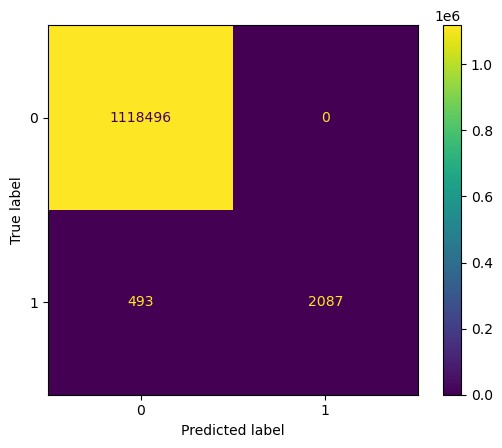

In [33]:
y_pred = dtc.predict(X_test)
print("Avg accuracy: ", dtc.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot(values_format='d')


Classification Report:
                 precision    recall  f1-score   support

Background/Safe       1.00      1.00      1.00   1118496
         Botnet       1.00      0.81      0.89      2580

       accuracy                           1.00   1121076
      macro avg       1.00      0.90      0.95   1121076
   weighted avg       1.00      1.00      1.00   1121076



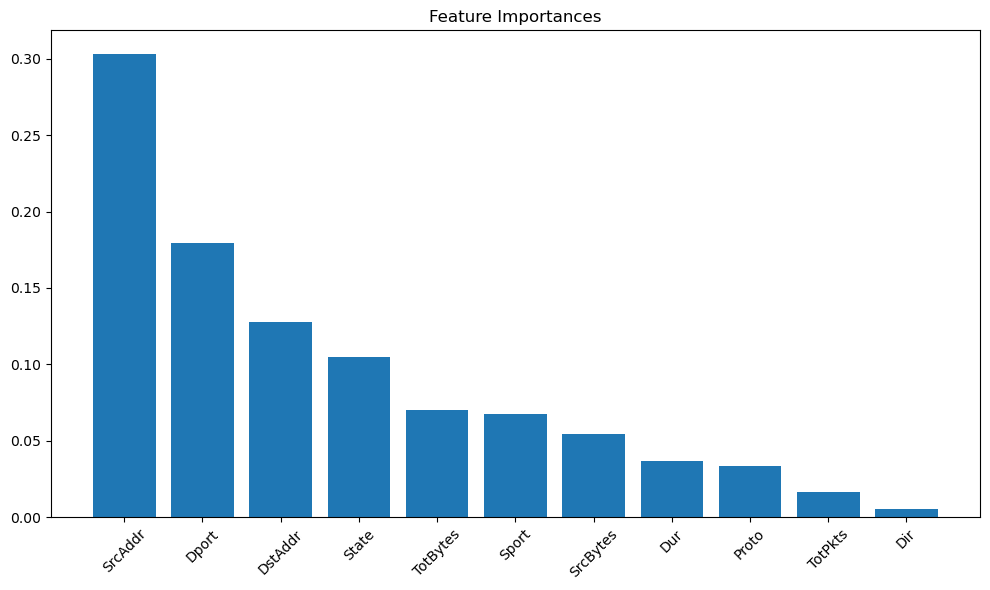

In [34]:
# 3. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Background/Safe', 'Botnet']))

# 4. Feature Importance Plot 
# This helps you understand WHAT the botnet is actually doing
importances = dtc.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.tight_layout()
plt.show()




In [35]:
'''


print("Initializing Random Forest...")

# We use class_weight='balanced' because Botnets are only a small % of data.
# n_jobs=-1 uses all CPU cores to speed up processing of 2M+ rows.
rf_model = RandomForestClassifier(
    n_estimators=50,       # Start with 50 trees for speed
    max_depth=20,          # Limit depth to prevent overfitting and save RAM
    n_jobs=-1, 
    random_state=42,
    class_weight='balanced',
    verbose=1
)

print("Training model... (This might take a few minutes)")
rf_model.fit(X_train, y_train)

print("Training complete.")


'''

'\n\n\nprint("Initializing Random Forest...")\n\n# We use class_weight=\'balanced\' because Botnets are only a small % of data.\n# n_jobs=-1 uses all CPU cores to speed up processing of 2M+ rows.\nrf_model = RandomForestClassifier(\n    n_estimators=50,       # Start with 50 trees for speed\n    max_depth=20,          # Limit depth to prevent overfitting and save RAM\n    n_jobs=-1, \n    random_state=42,\n    class_weight=\'balanced\',\n    verbose=1\n)\n\nprint("Training model... (This might take a few minutes)")\nrf_model.fit(X_train, y_train)\n\nprint("Training complete.")\n\n\n'

In [36]:
'''print("--- Model Performance ---")

# 1. Predict
y_pred = rf_model.predict(X_test)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 3. Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Background/Safe', 'Botnet']))

# 4. Feature Importance Plot 
# This helps you understand WHAT the botnet is actually doing
importances = rf_model.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

'''

'print("--- Model Performance ---")\n\n# 1. Predict\ny_pred = rf_model.predict(X_test)\n\n# 2. Confusion Matrix\ncm = confusion_matrix(y_test, y_pred)\nprint("\nConfusion Matrix:")\nprint(cm)\n\n# 3. Detailed Report\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred, target_names=[\'Background/Safe\', \'Botnet\']))\n\n# 4. Feature Importance Plot \n# This helps you understand WHAT the botnet is actually doing\nimportances = rf_model.feature_importances_\nindices = importances.argsort()[::-1]\n\nplt.figure(figsize=(10, 6))\nplt.title("Feature Importances")\nplt.bar(range(X_train.shape[1]), importances[indices], align="center")\nplt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)\nplt.tight_layout()\nplt.show()\n\n'